In [1]:
import os
import time
import requests
import tempfile
import numpy as np
import nibabel as nib
from typing import List, Tuple, Dict, Any, Optional

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

def cbam_block(inputs, ratio=8):
    channel = inputs.shape[-1]
    shared_layer_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
    avg_pool = layers.GlobalAveragePooling3D()(inputs)
    avg_pool = layers.Reshape((1, 1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    max_pool = layers.GlobalMaxPooling3D()(inputs)
    max_pool = layers.Reshape((1, 1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    attention = layers.Add()([avg_pool, max_pool])
    attention = layers.Activation('sigmoid')(attention)
    channel_att = layers.Multiply()([inputs, attention])
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_att)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_att)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv3D(filters=1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    return layers.Multiply()([channel_att, attention])

def build_attention_lstm_unet(input_shape, base_filters=16):
    print(f" The empty skeleton of the model is created.")
    inputs = layers.Input(shape=input_shape)
    # --- ENCODER ---
    conv1 = layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(inputs))))
    att1 = cbam_block(conv1)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(att1)
    conv2 = layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(pool1))))
    att2 = cbam_block(conv2)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(att2)
    # --- BOTTLENECK ---
    bottleneck = layers.Conv3D(base_filters * 4, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(pool2))
    _, D, H, W, F = bottleneck.shape
    bottleneck_reshaped = layers.Reshape((-1, F))(bottleneck)
    lstm_out = layers.Bidirectional(layers.LSTM(base_filters * 2, return_sequences=True))(bottleneck_reshaped)
    lstm_out_reshaped = layers.Reshape((D, H, W, base_filters * 4))(lstm_out)
    # --- DECODER ---
    up3 = layers.Conv3DTranspose(base_filters * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(lstm_out_reshaped)
    merge3 = layers.Concatenate(axis=-1)([up3, att2])
    conv3 = layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(merge3))))
    up4 = layers.Conv3DTranspose(base_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv3)
    merge4 = layers.Concatenate(axis=-1)([up4, att1])
    conv4 = layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(merge4))))
    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(conv4)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def psnr(y_true, y_pred): return tf.image.psnr(y_true, y_pred, max_val=1.0)
def ssim(y_true, y_pred): return tf.image.ssim(y_true, y_pred, max_val=1.0)

# ===================================================================

MODEL_PATH = "model_2.keras"

# STEP 1: First create an empty copy of the model.
# We write the input shape by hand, because there is no generator yet.
input_shape = (48, 64, 64, 1)
trained_model = build_attention_lstm_unet(input_shape)

try:
    # STEP 2: Now load only the weights into this empty model. 
    print(f"⚖️ Ağırlıklar yükleniyor: {MODEL_PATH}")
    trained_model.load_weights(MODEL_PATH)
    print("The model successfully loaded the weights!")
    
    # STEP 3: Compile the model to use it
    print(" The model is being assembled for testing.")
    trained_model.compile(loss='binary_crossentropy', metrics=['mae', psnr, ssim])
    print("The model is ready for testing!")

except Exception as e:
    print(f" Error loading weights: {e}")
    trained_model = None

if trained_model:
    trained_model.summary()
    print("\nThe model is loaded. Now you can prepare and evaluate test data.")

2025-06-09 21:07:42.670698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749503262.905515      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749503262.973898      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🧠 Modelin boş iskeleti oluşturuluyor...


I0000 00:00:1749503277.329213      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749503277.330028      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


⚖️ Ağırlıklar yükleniyor: /kaggle/input/fmri-final-model/tensorflow2/default/1/best_denoising_model.keras
✅ Model ağırlıkları başarıyla yüklendi!
⚙️ Model, test için derleniyor...
✅ Model test edilmeye hazır!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 64, 64, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 48, 64, 64, 1)  │              4 │ input_layer[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 48, 64, 64, 16) │            448 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 48, 64, 64, 16) │             64 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 48, 64, 64, 16) │          6,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling3d  │ (None, 16)             │              0 │ conv3d[0][0]           │
│ (GlobalAveragePooling3D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling3d      │ (None, 16)             │              0 │ conv3d[0][0]           │
│ (GlobalMaxPooling3D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 1, 16)    │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 1, 16)    │              0 │ global_max_pooling3d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 1, 2)     │             34 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 1, 16)    │             48 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 1, 16)    │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 1, 16)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 48, 64, 64, 16) │              0 │ conv3d[0][0],          │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 48, 64, 64, 1)  │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)    

 Total params: 256,135 (1000.53 KB)

 Trainable params: 255,653 (998.64 KB)

 Non-trainable params: 482 (1.88 KB)


Model yüklendi. Şimdi test verisi hazırlayıp değerlendirme yapabilirsiniz.



🧪 Test için küçük bir veri seti hazırlanıyor...
📥 Test verisi indiriliyor: sub-05_task-training_run-01_bold.nii.gz
📥 Test verisi indiriliyor: sub-05_task-training_run-02_bold.nii.gz
✅ Test veri jeneratörü hazır!

📈 Yüklenen model test seti üzerinde değerlendiriliyor...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749503366.939896     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - loss: 0.1756 - mae: 0.0121 - psnr: 33.3236 - ssim: 0.7987

📊 Test Seti Performansı:
   - loss: 0.1760
   - mae: 0.0122
   - psnr: 33.2791
   - ssim: 0.7965

📸 Sonuçlar görselleştiriliyor...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


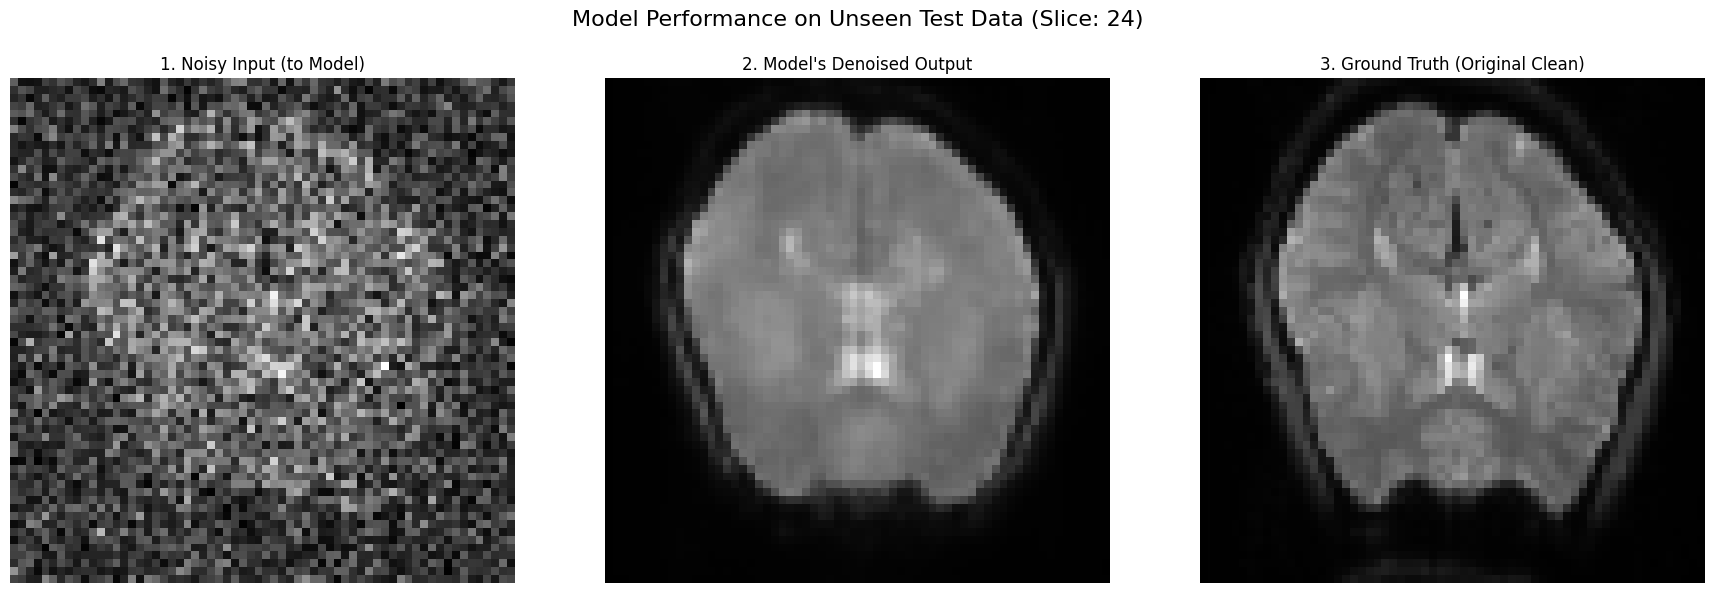

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import requests
import tempfile
import nibabel as nib
from scipy.ndimage import zoom
import math
from typing import List, Tuple

# ===================================================================
# PART 1: NECESSARY AUXILIARY TOOLS
# These are required to prepare the test data.
# ===================================================================

# 1.1 - Streamer for test data download
class OpenNeuroStreamer:
    def __init__(self, dataset_id: str = "ds002306"):
        self.dataset_id = dataset_id
        self.base_url = f"https://s3.amazonaws.com/openneuro.org/{dataset_id}"

    def check_url_exists(self, url: str) -> bool:
        try:
            response = requests.head(url, timeout=15)
            return response.status_code == 200
        except requests.exceptions.RequestException:
            return False

    def stream_nii_file(self, url: str) -> np.ndarray | None:
        print(f" Downloading test data: {os.path.basename(url)}")
        temp_path = None
        try:
            with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as temp_file:
                temp_path = temp_file.name
                response = requests.get(url, stream=True, timeout=60)
                response.raise_for_status()
                for chunk in response.iter_content(chunk_size=8192):
                    temp_file.write(chunk)
            img = nib.load(temp_path)
            return img.get_fdata(dtype=np.float32)
        except Exception as e:
            print(f" Error: {e}")
            return None
        finally:
            if temp_path and os.path.exists(temp_path):
                os.unlink(temp_path)
    
    def load_test_data(self, subjects: List[str], max_files: int = 2) -> List[np.ndarray]:
        loaded_data = []
        file_count = 0
        for subject in subjects:
            if file_count >= max_files: break
            for run_num in range(1, 6):
                if file_count >= max_files: break
                url = f"{self.base_url}/{subject}/func/{subject}_task-training_run-{run_num:02d}_bold.nii.gz"
                if self.check_url_exists(url):
                    data = self.stream_nii_file(url)
                    if data is not None:
                        loaded_data.append(data)
                        file_count += 1
        return loaded_data

# 1.2 - Generator for test data
class fMRIDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_arrays, batch_size=4, target_shape=(64, 64, 48), noise_level=0.1, shuffle=False):
        self.data_arrays = data_arrays
        self.batch_size = batch_size
        self.target_shape = target_shape
        self.noise_level = noise_level
        self.shuffle = shuffle
        self.indices = [(i, t) for i, data in enumerate(self.data_arrays) for t in range(data.shape[3])]
        self.on_epoch_end()
    def __len__(self):
        return math.floor(len(self.indices) / self.batch_size)
    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)
    def _resample_volume(self, volume):
        zoom_factors = [self.target_shape[d] / volume.shape[d] for d in range(3)]
        return zoom(volume, zoom_factors, order=1).astype(np.float32)
    def _normalize_volume(self, volume, v_min, v_max):
        return np.clip((volume - v_min) / (v_max - v_min + 1e-7), 0, 1)
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        # Set batch size dynamically (for last batch)
        current_batch_size = len(batch_indices)
        batch_shape = (current_batch_size, self.target_shape[2], self.target_shape[0], self.target_shape[1], 1)
        X, y = np.empty(batch_shape, dtype=np.float32), np.empty(batch_shape, dtype=np.float32)
        for i, (file_idx, time_idx) in enumerate(batch_indices):
            clean_volume_raw = self.data_arrays[file_idx][:, :, :, time_idx]
            clean_volume_resampled = self._resample_volume(clean_volume_raw)
            y_volume_norm = self._normalize_volume(clean_volume_resampled, 0, 3000)
            n1 = np.random.normal(0, self.noise_level, size=y_volume_norm.shape).astype('float32')
            n2 = np.random.normal(0, self.noise_level, size=y_volume_norm.shape).astype('float32')
            X_volume_norm = np.sqrt((y_volume_norm + n1)**2 + n2**2)
            y[i,] = np.transpose(y_volume_norm, (2, 0, 1))[..., np.newaxis]
            X[i,] = np.transpose(X_volume_norm, (2, 0, 1))[..., np.newaxis]
        return X, y

# ===================================================================
# PART 2: MAIN TEST AND VISUALIZATION CODE
# ===================================================================

# Check if the 'trained_model' variable exists
if 'trained_model' in globals() and trained_model is not None:
    print("\n A small data set is being prepared for testing...")
    streamer = OpenNeuroStreamer()
    # It is best to choose a different participant who has not been used in training.
    # For example, sub-04 or sub-05 is a good choice if you have trained with the first 10 files.
    test_data_runs = streamer.load_test_data(subjects=["sub-05"], max_files=2)

    if test_data_runs:
        test_generator = fMRIDataGenerator(
            data_arrays=test_data_runs,
            batch_size=4, # When testing batch size is not very important, you can stay at 4
            shuffle=False
        )
        test_ds = test_generator
        print("Test data generator ready!")

        # STEP 1: Test the model (Numerical Metrics)
        print("The uploaded model is being evaluated on a test set...")
        test_metrics = trained_model.evaluate(test_ds, return_dict=True)
        print("\nTest Set Performance:")
        for key, value in test_metrics.items():
            print(f"   - {key}: {value:.4f}")

        # STEP 2: Visualize Results
        print("\ Visualizing the results...")
        # Receive a batch test data from the generator
        x_test_batch, y_test_batch = test_ds.__getitem__(0)
        # Get the prediction of the model
        y_pred_batch = trained_model.predict(x_test_batch)

        # Select an instance to visualize (first element of the batch)
        sample_idx_to_show = 0
        # Select a cross-section through the center of the volume
        slice_idx = x_test_batch.shape[1] // 2

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"Model Performance on Unseen Test Data (Slice: {slice_idx})", fontsize=16)
        
        # Noisy Entry
        axes[0].imshow(np.rot90(x_test_batch[sample_idx_to_show, slice_idx, :, :, 0]), cmap='gray', origin='lower')
        axes[0].set_title('1. Noisy Input (to Model)')
        axes[0].axis('off')

        # Output of the Model
        axes[1].imshow(np.rot90(y_pred_batch[sample_idx_to_show, slice_idx, :, :, 0]), cmap='gray', origin='lower')
        axes[1].set_title("2. Model's Denoised Output")
        axes[1].axis('off')
        
        # As It Should Be (Real Clean Image)
        axes[2].imshow(np.rot90(y_test_batch[sample_idx_to_show, slice_idx, :, :, 0]), cmap='gray', origin='lower')
        axes[2].set_title('3. Ground Truth (Original Clean)')
        axes[2].axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    else:
        print(" Test data could not be downloaded. Check your internet connection or participant number.")
else:
    print("'trained_model' was not found. Please run the code to install the model first.")

🧪 Visualizing multiple samples to check model consistency...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


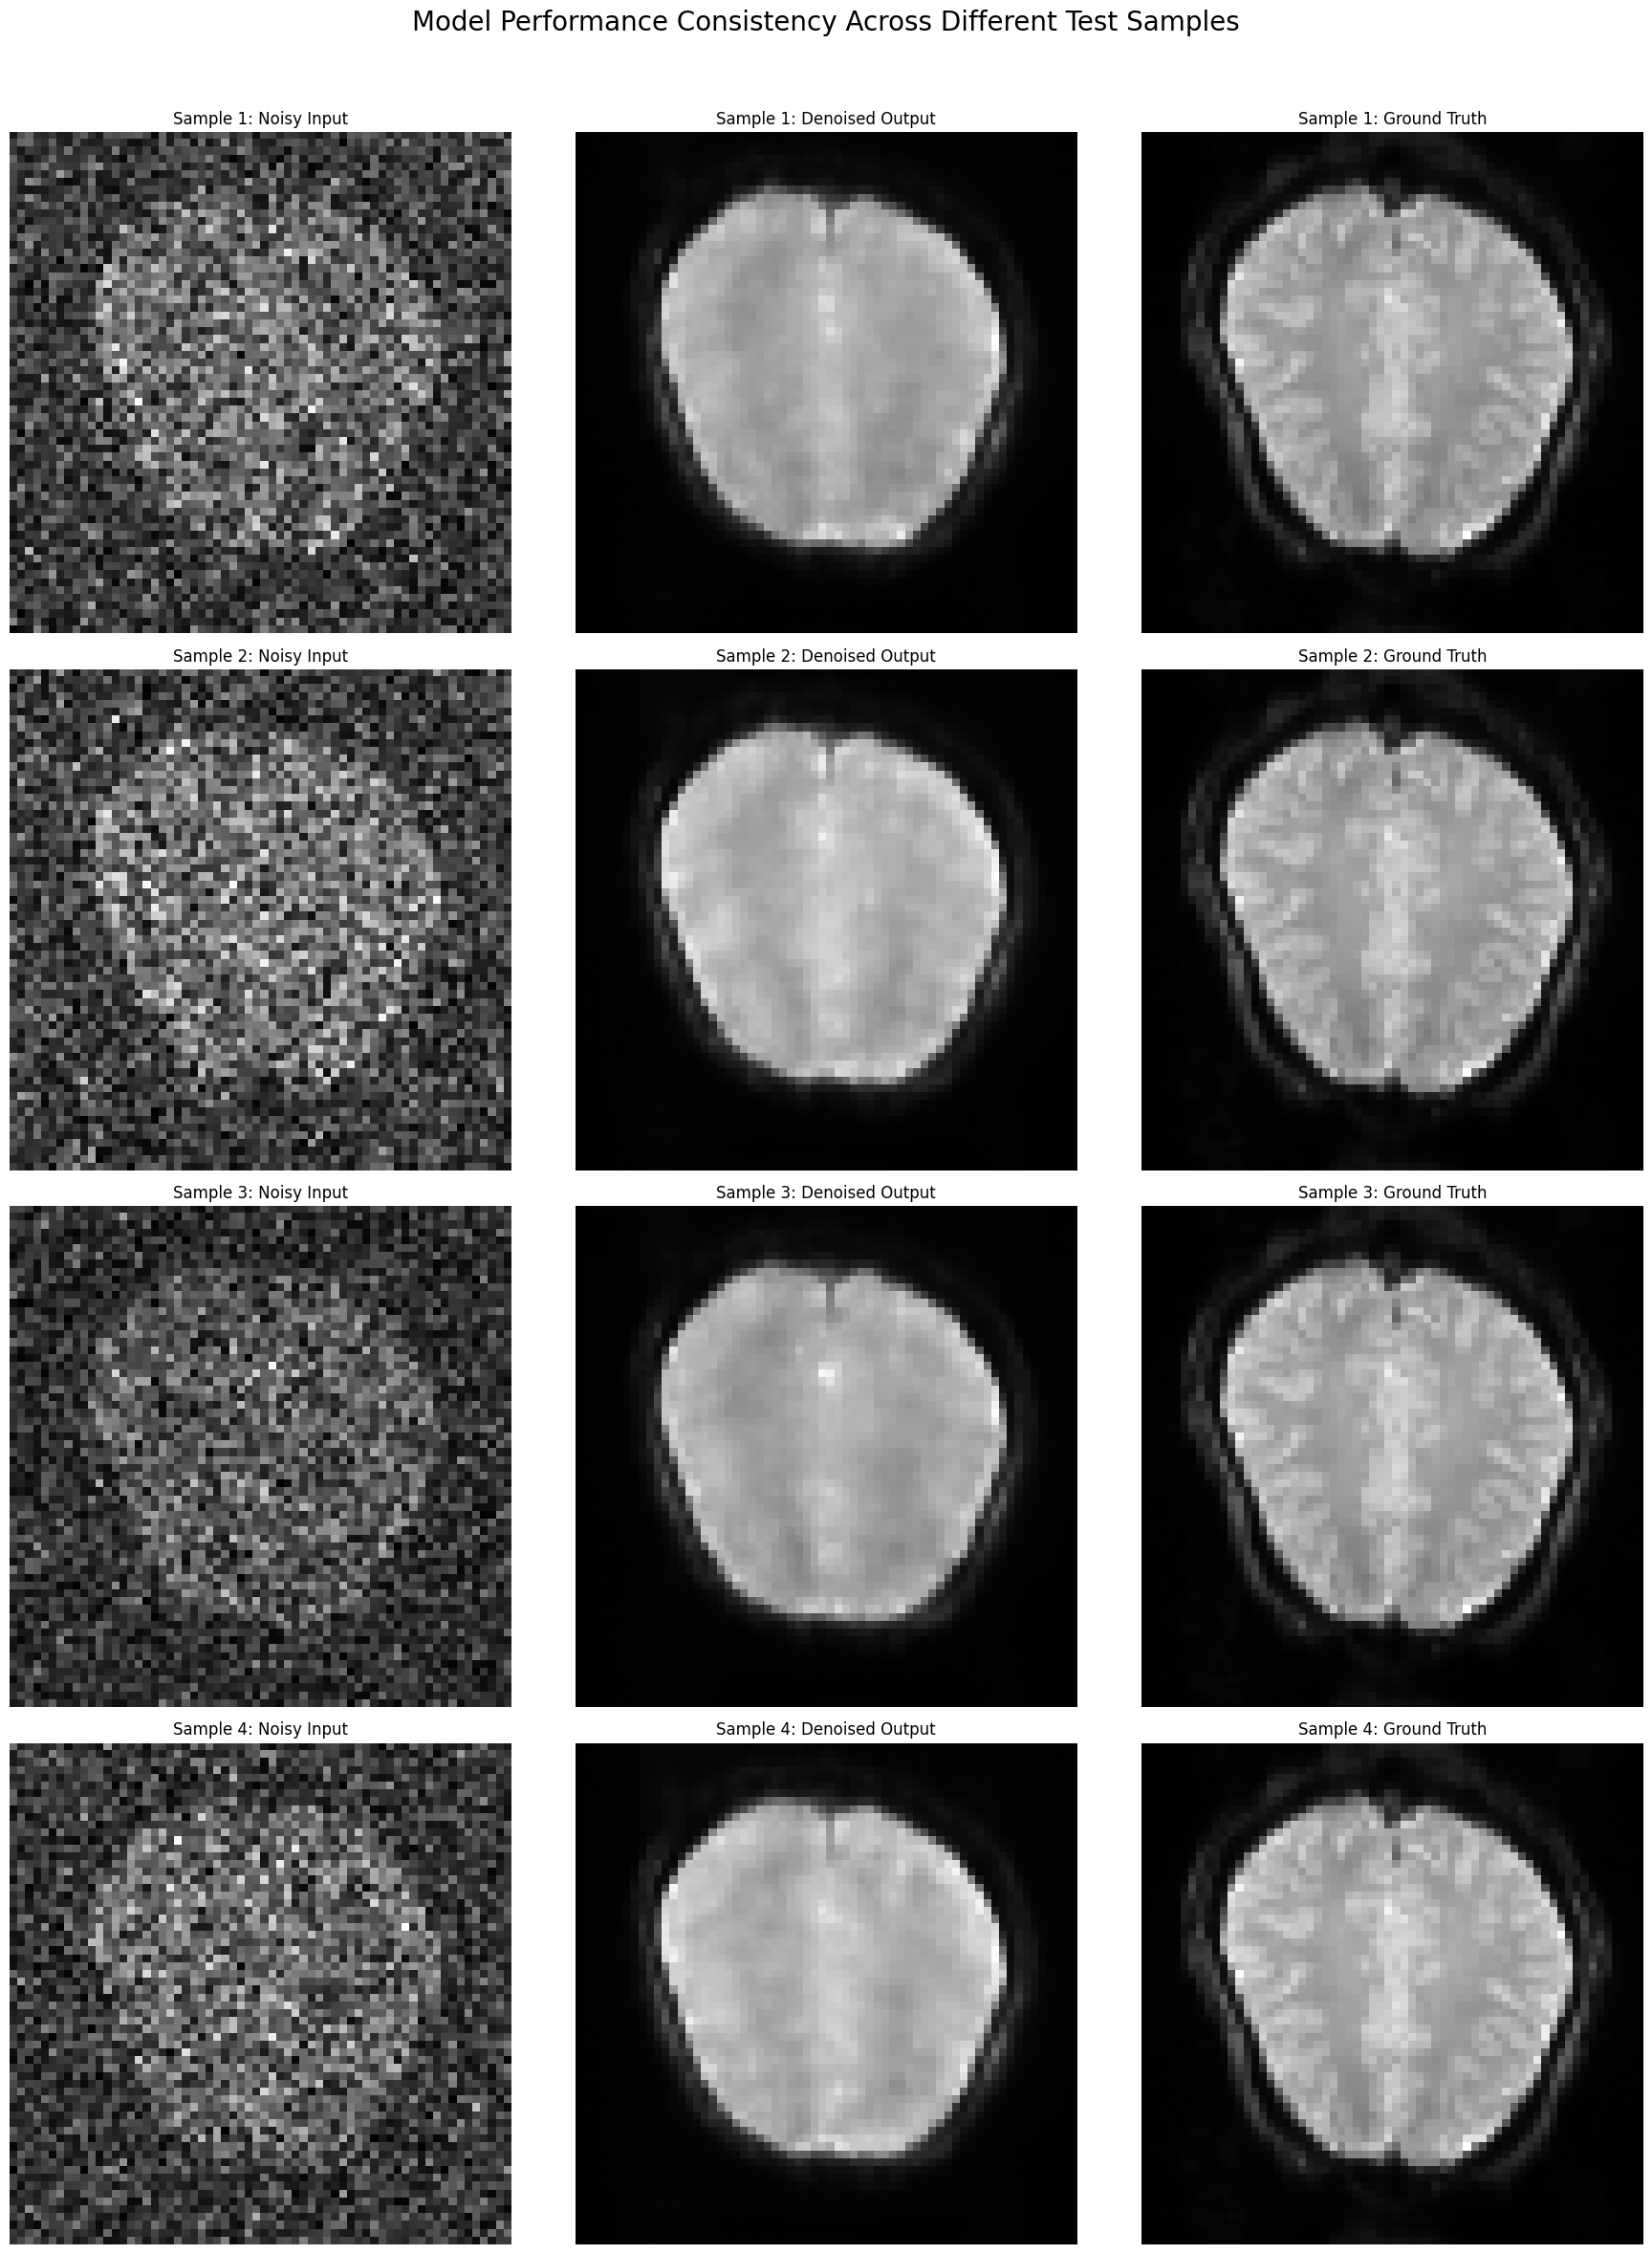

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Check if the necessary variables 'trained_model' and 'test_ds' exist
if 'trained_model' in globals() and 'test_ds' in globals():
    
    print("Visualizing multiple samples to check model consistency...")
    
    # Let's specify how many samples we want to show
    num_samples_to_show = 4

    # Get the required number of batches from the generator
    # Assuming 4 samples in each batch, we get enough batches
    num_batches_needed = (num_samples_to_show + test_ds.batch_size - 1) // test_ds.batch_size
    
    x_batches, y_batches = [], []
    for i in range(num_batches_needed):
        x_batch, y_batch = test_ds.__getitem__(i)
        x_batches.append(x_batch)
        y_batches.append(y_batch)
    
    # Merge batches into one large array
    x_test_samples = np.concatenate(x_batches, axis=0)
    y_test_samples = np.concatenate(y_batches, axis=0)

    # Let's make predictions on selected examples
    y_pred_samples = trained_model.predict(x_test_samples)

    # Visualization
    # Let's create a subplot with one row for each instance
    fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(18, 6 * num_samples_to_show))
    
    # If we show a single instance we need to adjust the size of axes
    if num_samples_to_show == 1:
        axes = np.array([axes])

    fig.suptitle("Model Performance Consistency Across Different Test Samples", fontsize=20)

    for i in range(num_samples_to_show):
        # Let's take the middle section for each sample
        slice_idx = x_test_samples.shape[2] // 2 

        # Assign related images to variables
        noisy_img = x_test_samples[i, slice_idx, :, :, 0]
        denoised_img = y_pred_samples[i, slice_idx, :, :, 0]
        original_img = y_test_samples[i, slice_idx, :, :, 0]

        # Noisy Entry
        axes[i, 0].imshow(np.rot90(noisy_img), cmap='gray', origin='lower')
        axes[i, 0].set_title(f"Sample {i+1}: Noisy Input")
        axes[i, 0].axis('off')

        # Output of the Model
        axes[i, 1].imshow(np.rot90(denoised_img), cmap='gray', origin='lower')
        axes[i, 1].set_title(f"Sample {i+1}: Denoised Output")
        axes[i, 1].axis('off')
        
        # As It Should Be (Real Clean Image)
        axes[i, 2].imshow(np.rot90(original_img), cmap='gray', origin='lower')
        axes[i, 2].set_title(f"Sample {i+1}: Ground Truth")
        axes[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("'trained_model' or 'test_ds' object not found.")
    print(" Please run the model loading and test data preparation cells first.")

In [7]:
# ===================================================================
# PREPARING DATA GENERATORS FOR FINE-TUNING
# ===================================================================

# Check if necessary classes like OpenNeuroStreamer and fMRIDataGenerator exist
if 'OpenNeuroStreamer' in globals() and 'fMRIDataGenerator' in globals():
    
    print(" Preparing data generators for fine-tuning...")
    
    streamer = OpenNeuroStreamer()
    
    # A small data set is enough for fine-tuning. Let's download 4-6 files in total.
    # It might be a good idea to choose different participants that have not been used in the training.
    print(" Downloading a small dataset for fine-tuning...")
    finetune_data_files = streamer.load_test_data(subjects=["sub-06", "sub-07"], max_files=4)

    if finetune_data_files:
        # Separate the downloaded files into train and validation (e.g. 3 to 1)
        train_runs = finetune_data_files[:3]
        val_runs = finetune_data_files[3:]

        print(f"\n Fine-tuning data split: {len(train_runs)} train files, {len(val_runs)} validation files.")

        BATCH_SIZE = 4 # Keep it the same as previous training

        # Let's create generators
        train_ds = fMRIDataGenerator(
            data_arrays=train_runs,
            batch_size=BATCH_SIZE,
            shuffle=True # Training data should always be scrambled
        )
        
        val_ds = fMRIDataGenerator(
            data_arrays=val_runs,
            batch_size=BATCH_SIZE,
            shuffle=False
        )
        
        print("'train_ds' and 'val_ds' are now ready for fine-tuning!")
        
    else:
        print("Could not download data for fine-tuning. Check internet connection or subject IDs.")

else:
    print("Helper classes (OpenNeuroStreamer, fMRIDataGenerator) not found.")
    print("Please make sure to run the cell containing these class definitions first.")

🛠️ Preparing data generators for fine-tuning...
📥 Downloading a small dataset for fine-tuning...
📥 Test verisi indiriliyor: sub-06_task-training_run-01_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-02_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-03_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-04_bold.nii.gz

📊 Fine-tuning data split: 3 train files, 1 validation files.
✅ 'train_ds' and 'val_ds' are now ready for fine-tuning!


In [11]:
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import requests
import tempfile
import nibabel as nib
from scipy.ndimage import zoom
import math
from typing import List, Tuple

# ===================================================================
# PART 1: NECESSARY AUXILIARY TOOLS
# Needed to prepare data for fine-tuning and to compile the model.
# ===================================================================

# 1.1 - Streamer and Generator Classes
# (We assume that these classes were defined in a previous cell.
# If they were deleted, this code will not work).
if 'OpenNeuroStreamer' not in globals() or 'fMRIDataGenerator' not in globals():
    print(" Helper classes (OpenNeuroStreamer, fMRIDataGenerator) not found.")
    print("Please make sure to run the cell containing these class definitions first.")
    # We can add the full code for these classes here if needed.

# 1.2 - Special Metrics and Corrected Combined Loss Function
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def composite_loss(y_true, y_pred):
    """
    Corrected loss function for
 AttributeError error, taking into account both pixel error (MAE) and structural similarity (SSIM).
    """
    # MAE (L1 Loss)
    mae_calculator = tf.keras.losses.MeanAbsoluteError()
    mae_loss = mae_calculator(y_true, y_pred)
    
    # SSIM Loss
    ssim_loss = 1.0 - tf.image.ssim(y_pred, y_true, max_val=1.0)
    
    # Consolidate losses. We put more weight on SSIM (80%).
    alpha = 0.8
    return (1 - alpha) * mae_loss + alpha * ssim_loss

# ===================================================================
# PART 2: MAIN FINE-TUNING PROCESS
# ===================================================================

# Check for the existence of required variables
if 'trained_model' in globals() and 'test_ds' in globals():
    
    # STEP 1: Prepare data generators for fine-tuning
    print("Preparing data generators for fine-tuning...")
    streamer = OpenNeuroStreamer()
    print("Downloading a small dataset for fine-tuning...")
    finetune_data_files = streamer.load_test_data(subjects=["sub-06", "sub-07"], max_files=4)

    if finetune_data_files:
        train_runs = finetune_data_files[:3]
        val_runs = finetune_data_files[3:]
        print(f"Fine-tuning data split: {len(train_runs)} train, {len(val_runs)} validation files.")

        BATCH_SIZE = 4
        train_ds = fMRIDataGenerator(data_arrays=train_runs, batch_size=BATCH_SIZE, shuffle=True)
        val_ds = fMRIDataGenerator(data_arrays=val_runs, batch_size=BATCH_SIZE, shuffle=False)
        print("'train_ds' and 'val_ds' are now ready for fine-tuning!")
        
        # STEP 2: Start the fine-tuning process
        print("\n" + "="*60)
        print("FINE-TUNING PROCESS INITIATED")
        print("="*60)
        
        fine_tune_lr = 1e-5
        print(f"Re-compiling the model for fine-tuning with learning rate {fine_tune_lr}...")
        
        trained_model.compile(
            optimizer=optimizers.Adam(learning_rate=fine_tune_lr),
            loss=composite_loss,
            metrics=['mae', psnr, ssim]
        )
        print("Model re-compiled successfully.")
        
        fine_tune_epochs = 15
        print(f"\n Starting fine-tuning for {fine_tune_epochs} epochs...")
        
        # Fine-tune the model
        history_finetune = trained_model.fit(
            train_ds,
            epochs=fine_tune_epochs,
            validation_data=val_ds
        )
        
        print("\n Fine-tuning complete!")

        # STEP 3: Evaluate the results
        print("\n Evaluating the fine-tuned model on the test set...")
        finetuned_metrics = trained_model.evaluate(test_ds, return_dict=True)
        
        print("\n Fine-Tuned Model Test Set Performance:")
        for key, value in finetuned_metrics.items():
            print(f"   - {key}: {value:.4f}")

    else:
        print("Could not download data for fine-tuning. Check internet connection.")
else:
    print("'trained_model' or 'test_ds' not found.")
    print("Please run the model loading and initial test data preparation cells first.")

🛠️ Preparing data generators for fine-tuning...
📥 Downloading a small dataset for fine-tuning...
📥 Test verisi indiriliyor: sub-06_task-training_run-01_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-02_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-03_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-04_bold.nii.gz
📊 Fine-tuning data split: 3 train, 1 validation files.
✅ 'train_ds' and 'val_ds' are now ready for fine-tuning!

🚀 FINE-TUNING PROCESS INITIATED
⚙️ Re-compiling the model for fine-tuning with learning rate 1e-05...
✅ Model re-compiled successfully.

🎯 Starting fine-tuning for 15 epochs...
Epoch 1/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 116s 454ms/step - loss: 0.1185 - mae: 0.0113 - psnr: 34.1136 - ssim: 0.8547 - val_loss: 0.0948 - val_mae: 0.0098 - val_psnr: 35.1952 - val_ssim: 0.8840
Epoch 2/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 93s 443ms/step - loss: 0.0865 - mae: 0.0092 - psnr: 35.7863 - ssim: 0.8942 - val_loss: 0.0839 - val_mae: 0.0091 -

In [13]:
# ===================================================================
# IMPROVED FINE-TUNING PROCESS (ALL BUGS FIXED)
# ===================================================================

import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

# ===================================================================
# CONTROL AND IDENTIFICATION OF NECESSARY AUXILIARY TOOLS
# ===================================================================

# We assume that the necessary classes and functions were defined in a previous cell.
if 'OpenNeuroStreamer' not in globals() or 'fMRIDataGenerator' not in globals():
    print("  The required classes (Streamer/Generator) were not found. Please run the corresponding cell.")

def psnr(y_true, y_pred): return tf.image.psnr(y_true, y_pred, max_val=1.0)
def ssim(y_true, y_pred): return tf.image.ssim(y_true, y_pred, max_val=1.0)
def composite_loss(y_true, y_pred):
    mae_calculator = tf.keras.losses.MeanAbsoluteError()
    mae_loss = mae_calculator(y_true, y_pred)
    ssim_loss = 1.0 - tf.image.ssim(y_pred, y_true, max_val=1.0)
    alpha = 0.8
    return (1 - alpha) * mae_loss + alpha * ssim_loss

# ===================================================================
# IMPROVED FINE-TUNING PROCESS (ALL BUGS FIXED)
# ===================================================================

if 'trained_model' in globals() and 'test_ds' in globals():
    
    # STEP 1: Prepare MORE data for fine-tuning
    print("Preparing a larger dataset for fine-tuning...")
    streamer = OpenNeuroStreamer()
    # Let's try to download up to 8 files from different participants
    finetune_data_files = streamer.load_test_data(subjects=["sub-06", "sub-07", "sub-08", "sub-09"], max_files=8)

    if finetune_data_files:
        # --- DATA SEPARATION CORRECTION ---
        # Allocate 80% of found files as train and the rest as validation
        num_files = len(finetune_data_files)
        train_split_index = int(num_files * 0.8)
        
        train_runs = finetune_data_files[:train_split_index]
        val_runs = finetune_data_files[train_split_index:]

        # Check so that the validation set is not empty
        if not val_runs and train_runs:
             val_runs = [train_runs.pop()] # Take one from Train

        print(f"📊 Fine-tuning data split: {len(train_runs)} train, {len(val_runs)} validation files.")

        BATCH_SIZE = 4
        train_ds = fMRIDataGenerator(data_arrays=train_runs, batch_size=BATCH_SIZE, shuffle=True)
        val_ds = fMRIDataGenerator(data_arrays=val_runs, batch_size=BATCH_SIZE, shuffle=False)
        print("Data generators are ready.")
        
        # STEP 2: Layer Freezing - THE CORRECT METHOD
        print("\n" + "="*60)
        print("Freezing the Encoder layers to preserve learned features...")
        
        # Freeze until you find the first Conv3DTranspose layer where the Decoder starts.
        freeze_active = True
        for layer in trained_model.layers:
            if isinstance(layer, layers.Conv3DTranspose):
                freeze_active = False # Stop freezing from this layer
            layer.trainable = not freeze_active

        print("Decoder (Conv3DTranspose and subsequent) layers are now trainable.")
        
        # STEP 3: Build the Model with New Rules
        fine_tune_lr = 5e-5
        print(f" Re-compiling the model for fine-tuning. Learning rate: {fine_tune_lr}")
        
        trained_model.compile(
            optimizer=optimizers.Adam(learning_rate=fine_tune_lr),
            loss=composite_loss,
            metrics=['mae', psnr, ssim]
        )
        # Print the number of trainable parameters to see the change
        trained_model.summary()

        # STEP 4: Start Fine-Tuning Training
        fine_tune_epochs = 20
        print(f"\n🎯 Starting ADVANCED fine-tuning for {fine_tune_epochs} epochs...")
        
        history_finetune_advanced = trained_model.fit(
            train_ds,
            epochs=fine_tune_epochs,
            validation_data=val_ds
        )
        
        print("\n Advanced Fine-tuning complete!")

        # STEP 5: Final Evaluation
        print("\n Evaluating the fine-tuned model on the test set...")
        finetuned_metrics = trained_model.evaluate(test_ds, return_dict=True)
        print("\n Advanced Fine-Tuned Model Test Set Performance:")
        for key, value in finetuned_metrics.items(): print(f"   - {key}: {value:.4f}")

    else:
        print("Could not download data for fine-tuning.")
else:
    print("'trained_model' or 'test_ds' not found.")

🛠️ Preparing a larger dataset for fine-tuning...
📥 Test verisi indiriliyor: sub-06_task-training_run-01_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-02_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-03_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-04_bold.nii.gz
📥 Test verisi indiriliyor: sub-06_task-training_run-05_bold.nii.gz
📊 Fine-tuning data split: 4 train, 1 validation files.
✅ Data generators are ready.

❄️ Freezing the Encoder layers to preserve learned features...
Decoder (Conv3DTranspose and subsequent) layers are now trainable.
⚙️ Re-compiling the model for fine-tuning. Learning rate: 5e-05


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 64, 64, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 48, 64, 64, 1)  │              4 │ input_layer[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 48, 64, 64, 16) │            448 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 48, 64, 64, 16) │             64 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 48, 64, 64, 16) │          6,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling3d  │ (None, 16)             │              0 │ conv3d[0][0]           │
│ (GlobalAveragePooling3D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling3d      │ (None, 16)             │              0 │ conv3d[0][0]           │
│ (GlobalMaxPooling3D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 1, 16)    │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 1, 16)    │              0 │ global_max_pooling3d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 1, 2)     │             34 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 1, 16)    │             48 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 1, 16)    │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 1, 16)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 48, 64, 64, 16) │              0 │ conv3d[0][0],          │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 48, 64, 64, 1)  │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)    

 Total params: 256,135 (1000.53 KB)

 Trainable params: 124,609 (486.75 KB)

 Non-trainable params: 131,526 (513.77 KB)


🎯 Starting ADVANCED fine-tuning for 20 epochs...
Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 94s 295ms/step - loss: 0.0520 - mae: 0.0071 - psnr: 38.0772 - ssim: 0.9368 - val_loss: 0.1223 - val_mae: 0.0117 - val_psnr: 33.7235 - val_ssim: 0.8501
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 284ms/step - loss: 0.0491 - mae: 0.0069 - psnr: 38.3343 - ssim: 0.9404 - val_loss: 0.1241 - val_mae: 0.0118 - val_psnr: 33.6386 - val_ssim: 0.8479
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 285ms/step - loss: 0.0471 - mae: 0.0068 - psnr: 38.5188 - ssim: 0.9429 - val_loss: 0.1249 - val_mae: 0.0120 - val_psnr: 33.5465 - val_ssim: 0.8469
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 283ms/step - loss: 0.0453 - mae: 0.0067 - psnr: 38.6749 - ssim: 0.9450 - val_loss: 0.1257 - val_mae: 0.0120 - val_psnr: 33.5422 - val_ssim: 0.8459
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 284ms/step - loss: 0.0441 - mae: 0.0066 - psnr: 38.7962 - ssim: 0.9466 - val_loss: 0.1264 - val_mae: 0.0120 - val_psnr: 33.5356 - val_ssim: 0.